In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd
import os
import sys

# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)

<module 'pdo_functions' from '/scratch/ivyglade/pdo/pdo_functions.py'>

In [2]:
# Open environmental data
cape = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/wrf_cape/era5_daily_max_mucape_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']
s06 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/era5_s06_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']
ndsev = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/diff_trapp_ndsev_mam_1940-2024.nc')['__xarray_dataarray_variable__']

In [3]:
# Need to compute monthly means
ndsev_monthly = np.zeros((85, 101, 237))
for i in range(85):
    # Load in one year of data
    ndsev_monthly[i] = ndsev.isel(time=slice(i*92, (i+1)*92)).transpose('time', 'latitude', 'longitude').values.sum(axis=0)
    
    # Progress
    print(f'{1940+i} is complete.')

1940 is complete.
1941 is complete.
1942 is complete.
1943 is complete.
1944 is complete.
1945 is complete.
1946 is complete.
1947 is complete.
1948 is complete.
1949 is complete.
1950 is complete.
1951 is complete.
1952 is complete.
1953 is complete.
1954 is complete.
1955 is complete.
1956 is complete.
1957 is complete.
1958 is complete.
1959 is complete.
1960 is complete.
1961 is complete.
1962 is complete.
1963 is complete.
1964 is complete.
1965 is complete.
1966 is complete.
1967 is complete.
1968 is complete.
1969 is complete.
1970 is complete.
1971 is complete.
1972 is complete.
1973 is complete.
1974 is complete.
1975 is complete.
1976 is complete.
1977 is complete.
1978 is complete.
1979 is complete.
1980 is complete.
1981 is complete.
1982 is complete.
1983 is complete.
1984 is complete.
1985 is complete.
1986 is complete.
1987 is complete.
1988 is complete.
1989 is complete.
1990 is complete.
1991 is complete.
1992 is complete.
1993 is complete.
1994 is complete.
1995 is co

In [4]:
# Select the CONUS - making sure that CAPE, S06 and NDSEV all have the same shape
cape_conus = cape.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
s06_conus  = s06.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [5]:
# Select MAM only
cape_conus_mam = cape_conus.sel(date=cape_conus.date.where(
                                     cape_conus.date.str.startswith('03-') |
                                     cape_conus.date.str.startswith('04-') |
                                     cape_conus.date.str.startswith('05-'),
                                     drop=True)).load()

s06_conus_mam = s06_conus.sel(time=s06_conus.time.dt.month.isin([3, 4, 5]))

In [6]:
# Flatten to have a single time dimension
cape_conus_mam_mean_stack = cape_conus_mam.stack(time=('year', 'date'))

# Convert time to datetime
year = cape_conus_mam_mean_stack['time'].get_index('time').get_level_values('year')
date = cape_conus_mam_mean_stack['time'].get_index('time').get_level_values('date')

datetime = pd.to_datetime(year.astype(str) + '-' + date.astype(str))

cape_conus_mam_mean_stack = cape_conus_mam_mean_stack.assign_coords(time=datetime)

/tmp/ipykernel_97599/906048647.py:10: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'date'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'year', 'date'])` before assigning new coordinate values.
  cape_conus_mam_mean_stack = cape_conus_mam_mean_stack.assign_coords(time=datetime)


In [7]:
# Take MAM mean
s06_conus_mam_mean = s06_conus_mam.resample(time='YE').mean().dropna(dim='time')
cape_conus_mam_mean = cape_conus_mam_mean_stack.resample(time='YE').mean().dropna(dim='time').transpose('time', 'latitude', 'longitude')

In [8]:
# Convert ndsev_monthly to XR
ndsev_conus = xr.DataArray(ndsev_monthly, coords={'time':cape_conus_mam_mean['time'], 'latitude':s06_conus_mam_mean['latitude'], 'longitude':s06_conus_mam_mean['longitude']}, dims=['time', 'latitude', 'longitude'])

In [9]:
# Detrend
cape_conus_mam_de = pdo_functions.detrend_dim(cape_conus_mam_mean, 'time', 2)
s06_conus_mam_de  = pdo_functions.detrend_dim(s06_conus_mam_mean, 'time', 2).load()
ndsev_conus_mam_de = pdo_functions.detrend_dim(ndsev_conus, 'time', 2)

In [10]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1870, 2024)

oni = pdo_functions.oni_moving_base(sst)

In [11]:
# 3- month rolling mean
oni_rolling = oni.rolling(time=3, center=True).mean()
oni_rolling_1940_2024 = oni_rolling.sel(time=oni_rolling.time.dt.year.isin(np.arange(1940, 2025, 1)))
oni_rolling_1940_2024_mam = oni_rolling_1940_2024.sel(time=oni_rolling_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

# Calculating when El Nino and La Nina events occur
oni_calc = np.zeros((1668))
for i in range(1668):
    if i < 5:
        continue
    else:
        if (oni_rolling[(i-4)] > 0.5) & (oni_rolling[(i-3)] > 0.5) & (oni_rolling[(i-2)] > 0.5) & (oni_rolling[(i-1)] > 0.5) & (oni_rolling[i] > 0.5):
            oni_calc[i] = 1
        elif (oni_rolling[(i-4)] < -0.5) & (oni_rolling[(i-3)] < -0.5) & (oni_rolling[(i-2)] < -0.5) & (oni_rolling[(i-1)] < -0.5) & (oni_rolling[i] < -0.5):
            oni_calc[i] = -1
        else:
            continue

# Coonvert to XR
oni_calc_xr = xr.DataArray(oni_calc, coords={'time':oni['time']}, dims=['time'])

# 1940-2024 only
oni_1940_2024 = oni_calc_xr.sel(time=oni_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
oni_1940_2024_mam = oni_1940_2024.sel(time=oni_1940_2024.time.dt.month.isin([3, 4, 5]))

# Need to calculate when El Nino/La Nina Occurs in a given year
oni_1940_2024_mam_ann = np.zeros((85))
for i in range(85):
    if oni_1940_2024_mam[i*3: (i+1)*3].sum(axis=0) > 0:
        oni_1940_2024_mam_ann[i] = 1

    elif oni_1940_2024_mam[i*3: (i+1)*3].sum(axis=0) < 0:
        oni_1940_2024_mam_ann[i] = -1

    else:
        continue

In [12]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':sst['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM and take seasonal averages
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

# aligning time arrays with that of CAPE
pdo_1940_2024_mam['time'] = cape_conus_mam_de['time']

s06_conus_mam_de['time'] = cape_conus_mam_de['time']
oni_rolling_1940_2024_mam['time'] = cape_conus_mam_de['time']

oni_ann_xr = xr.DataArray(oni_1940_2024_mam_ann, coords={'time':cape_conus_mam_de['time']}, dims=['time'])

In [138]:
# Compositing
cape_pos_pdo = xr.where(pdo_1940_2024_mam > 0, cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_pdo = xr.where(pdo_1940_2024_mam < 0, cape_conus_mam_de, np.nan).dropna(dim='time')

cape_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, cape_conus_mam_de, np.nan).dropna(dim='time')

cape_pos_nino = xr.where(oni_ann_xr == 1, cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_nina = xr.where(oni_ann_xr == -1, cape_conus_mam_de, np.nan).dropna(dim='time')

cape_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), cape_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_pdo = xr.where(pdo_1940_2024_mam > 0, s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_pdo = xr.where(pdo_1940_2024_mam < 0, s06_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, s06_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_nino = xr.where(oni_ann_xr == 1, s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_nina = xr.where(oni_ann_xr == -1, s06_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), s06_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_pdo = xr.where(pdo_1940_2024_mam > 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_pdo = xr.where(pdo_1940_2024_mam < 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_nino = xr.where(oni_ann_xr == 1, ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_nina = xr.where(oni_ann_xr == -1, ndsev_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), ndsev_conus_mam_de, np.nan).dropna(dim='time')

In [139]:
def bootstrap_p_values_fast(sample_mean, cape_climo, comp_cond, n_boot=10_000):
    n_lats, n_lons, n_time = cape_climo.shape
    n_comp = np.count_nonzero(comp_cond)

    # Flatten the spatial dimensions
    grid_size = n_lats * n_lons
    cape_flat = cape_climo.reshape(grid_size, n_time)
    sample_mean_flat = sample_mean.ravel()

    # Draw bootstrap samples for all grid points at once
    rand_idx = np.random.randint(0, n_time, size=(n_boot, n_comp))
    boot_samples = cape_flat[:, rand_idx]  # shape: (grid_size, n_boot, n_comp)

    # Mean across composite months
    boot_means = boot_samples.mean(axis=2)  # shape: (grid_size, n_boot)

    # Climatology mean for each grid point
    climo_mean = cape_flat.mean(axis=1)  # shape: (grid_size,)

    # Calculate p-values
    diffs = np.abs(boot_means - climo_mean[:, None])  # shape: (grid_size, n_boot)
    test_diffs = np.abs(sample_mean_flat - climo_mean)
    p_values_flat = np.mean(diffs >= test_diffs[:, None], axis=1)

    # Confidence intervals
    lower_flat = np.percentile(boot_means, 2.5, axis=1)
    upper_flat = np.percentile(boot_means, 97.5, axis=1)

    # Reshape back to (lat, lon)
    p_values = p_values_flat.reshape(n_lats, n_lons)
    lower_grid = lower_flat.reshape(n_lats, n_lons)
    upper_grid = upper_flat.reshape(n_lats, n_lons)

    return p_values, upper_grid, lower_grid

In [141]:
cape_pos_pdo_p_fast, cape_pos_pdo_upper_fast, cape_pos_pdo_lower_fast = bootstrap_p_values_fast(cape_pos_pdo.values.mean(axis=0), cape_conus_mam_de.transpose('latitude', 'longitude', 'time').values, pdo_1940_2024_mam.values > 0)

In [144]:
cape_pos_pdo_neut_nino_p_fast, cape_pos_pdo_neut_nino_upper_fast, cape_pos_pdo_neut_nino_lower_fast = bootstrap_p_values_fast(cape_pos_pdo_neut_oni.values.mean(axis=0), cape_conus_mam_de.transpose('latitude', 'longitude', 'time').values, (pdo_1940_2024_mam > 0) & (oni_ann_xr == 0))

In [103]:
cape_neg_pdo_p_fast, cape_neg_pdo_upper_fast, cape_neg_pdo_lower_fast = bootstrap_p_values_fast(cape_neg_pdo.values.mean(axis=0), cape_conus_mam_de.transpose('latitude', 'longitude', 'time').values, pdo_1940_2024_mam.values < 0)

In [145]:
cape_neg_pdo_neut_nino_p_fast, cape_neg_pdo_neut_nino_upper_fast, cape_neg_pdo_neut_nino_lower_fast = bootstrap_p_values_fast(cape_neg_pdo_neut_oni.values.mean(axis=0), cape_conus_mam_de.transpose('latitude', 'longitude', 'time').values, (pdo_1940_2024_mam < 0) & (oni_ann_xr == 0))

In [133]:
cape_pos_nino_p_fast, cape_pos_nino_upper_fast, cape_pos_nino_lower_fast = bootstrap_p_values_fast(cape_pos_nino.values.mean(axis=0), cape_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_ann_xr.values == 1)

In [147]:
cape_neg_nino_p_fast, cape_neg_nino_upper_fast, cape_neg_nino_lower_fast = bootstrap_p_values_fast(cape_neg_nina.values.mean(axis=0), cape_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_ann_xr.values == -1)

In [148]:
cape_pos_oni_p_fast, cape_pos_oni_upper_fast, cape_pos_oni_lower_fast = bootstrap_p_values_fast(cape_pos_oni.values.mean(axis=0), cape_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_rolling_1940_2024_mam > 0)

In [149]:
cape_neg_oni_p_fast, cape_neg_oni_upper_fast, cape_neg_oni_lower_fast = bootstrap_p_values_fast(cape_neg_oni.values.mean(axis=0), cape_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_rolling_1940_2024_mam < 0)

In [150]:
## Spacer ##

In [151]:
s06_pos_pdo_p_fast, s06_pos_pdo_upper_fast, s06_pos_pdo_lower_fast = bootstrap_p_values_fast(s06_pos_pdo.values.mean(axis=0), s06_conus_mam_de.transpose('latitude', 'longitude', 'time').values, pdo_1940_2024_mam.values > 0)

In [152]:
s06_pos_pdo_neut_nino_p_fast, s06_pos_pdo_neut_nino_upper_fast, s06_pos_pdo_neut_nino_lower_fast = bootstrap_p_values_fast(s06_pos_pdo_neut_oni.values.mean(axis=0), s06_conus_mam_de.transpose('latitude', 'longitude', 'time').values, (pdo_1940_2024_mam > 0) & (oni_ann_xr == 0))

In [153]:
s06_neg_pdo_p_fast, s06_neg_pdo_upper_fast, s06_neg_pdo_lower_fast = bootstrap_p_values_fast(s06_neg_pdo.values.mean(axis=0), s06_conus_mam_de.transpose('latitude', 'longitude', 'time').values, pdo_1940_2024_mam.values < 0)

In [154]:
s06_neg_pdo_neut_nino_p_fast, s06_neg_pdo_neut_nino_upper_fast, s06_neg_pdo_neut_nino_lower_fast = bootstrap_p_values_fast(s06_neg_pdo_neut_oni.values.mean(axis=0), s06_conus_mam_de.transpose('latitude', 'longitude', 'time').values, (pdo_1940_2024_mam < 0) & (oni_ann_xr == 0))

In [155]:
s06_pos_nino_p_fast, s06_pos_nino_upper_fast, s06_pos_nino_lower_fast = bootstrap_p_values_fast(s06_pos_nino.values.mean(axis=0), s06_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_ann_xr.values == 1)

In [156]:
s06_neg_nino_p_fast, s06_neg_nino_upper_fast, s06_neg_nino_lower_fast = bootstrap_p_values_fast(s06_neg_nina.values.mean(axis=0), s06_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_ann_xr.values == -1)

In [157]:
s06_pos_oni_p_fast, s06_pos_oni_upper_fast, s06_pos_oni_lower_fast = bootstrap_p_values_fast(s06_pos_oni.values.mean(axis=0), s06_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_rolling_1940_2024_mam > 0)

In [158]:
s06_neg_oni_p_fast, s06_neg_oni_upper_fast, s06_neg_oni_lower_fast = bootstrap_p_values_fast(s06_neg_oni.values.mean(axis=0), s06_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_rolling_1940_2024_mam < 0)

In [159]:
## Spacer ##

In [160]:
ndsev_pos_pdo_p_fast, ndsev_pos_pdo_upper_fast, ndsev_pos_pdo_lower_fast = bootstrap_p_values_fast(ndsev_pos_pdo.values.mean(axis=0), ndsev_conus_mam_de.transpose('latitude', 'longitude', 'time').values, pdo_1940_2024_mam.values > 0)

In [161]:
ndsev_pos_pdo_neut_nino_p_fast, ndsev_pos_pdo_neut_nino_upper_fast, ndsev_pos_pdo_neut_nino_lower_fast = bootstrap_p_values_fast(ndsev_pos_pdo_neut_oni.values.mean(axis=0), ndsev_conus_mam_de.transpose('latitude', 'longitude', 'time').values, (pdo_1940_2024_mam > 0) & (oni_ann_xr == 0))

In [162]:
ndsev_neg_pdo_p_fast, ndsev_neg_pdo_upper_fast, ndsev_neg_pdo_lower_fast = bootstrap_p_values_fast(ndsev_neg_pdo.values.mean(axis=0), ndsev_conus_mam_de.transpose('latitude', 'longitude', 'time').values, pdo_1940_2024_mam.values < 0)

In [163]:
ndsev_neg_pdo_neut_nino_p_fast, ndsev_neg_pdo_neut_nino_upper_fast, ndsev_neg_pdo_neut_nino_lower_fast = bootstrap_p_values_fast(ndsev_neg_pdo_neut_oni.values.mean(axis=0), ndsev_conus_mam_de.transpose('latitude', 'longitude', 'time').values, (pdo_1940_2024_mam < 0) & (oni_ann_xr == 0))

In [164]:
ndsev_pos_nino_p_fast, ndsev_pos_nino_upper_fast, ndsev_pos_nino_lower_fast = bootstrap_p_values_fast(ndsev_pos_nino.values.mean(axis=0), ndsev_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_ann_xr.values == 1)

In [165]:
ndsev_neg_nino_p_fast, ndsev_neg_nino_upper_fast, ndsev_neg_nino_lower_fast = bootstrap_p_values_fast(ndsev_neg_nina.values.mean(axis=0), ndsev_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_ann_xr.values == -1)

In [166]:
ndsev_pos_oni_p_fast, ndsev_pos_oni_upper_fast, ndsev_pos_oni_lower_fast = bootstrap_p_values_fast(ndsev_pos_oni.values.mean(axis=0), ndsev_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_rolling_1940_2024_mam > 0)

In [167]:
ndsev_neg_oni_p_fast, ndsev_neg_oni_upper_fast, ndsev_neg_oni_lower_fast = bootstrap_p_values_fast(ndsev_neg_oni.values.mean(axis=0), ndsev_conus_mam_de.transpose('latitude', 'longitude', 'time').values, oni_rolling_1940_2024_mam < 0)

In [168]:
## Spacer ##

In [171]:
cape_pos_pdo_adj_p = pdo_functions.control_FDR(cape_pos_pdo_p_fast, 101, 237, 0.1)
cape_neg_pdo_adj_p = pdo_functions.control_FDR(cape_neg_pdo_p_fast, 101, 237, 0.1)
cape_pos_pdo_neut_nino_adj_p = pdo_functions.control_FDR(cape_pos_pdo_neut_nino_p_fast, 101, 237, 0.1)
cape_neg_pdo_neut_nino_adj_p = pdo_functions.control_FDR(cape_neg_pdo_neut_nino_p_fast, 101, 237, 0.1)
cape_pos_oni_adj_p = pdo_functions.control_FDR(cape_pos_oni_p_fast, 101, 237, 0.1)
cape_neg_oni_adj_p = pdo_functions.control_FDR(cape_neg_oni_p_fast, 101, 237, 0.1)
cape_pos_nino_adj_p = pdo_functions.control_FDR(cape_pos_nino_p_fast, 101, 237, 0.1)
cape_neg_nino_adj_p = pdo_functions.control_FDR(cape_neg_nino_p_fast, 101, 237, 0.1)

s06_pos_pdo_adj_p = pdo_functions.control_FDR(s06_pos_pdo_p_fast, 101, 237, 0.1)
s06_neg_pdo_adj_p = pdo_functions.control_FDR(s06_neg_pdo_p_fast, 101, 237, 0.1)
s06_pos_pdo_neut_nino_adj_p = pdo_functions.control_FDR(s06_pos_pdo_neut_nino_p_fast, 101, 237, 0.1)
s06_neg_pdo_neut_nino_adj_p = pdo_functions.control_FDR(s06_neg_pdo_neut_nino_p_fast, 101, 237, 0.1)
s06_pos_oni_adj_p = pdo_functions.control_FDR(s06_pos_oni_p_fast, 101, 237, 0.1)
s06_neg_oni_adj_p = pdo_functions.control_FDR(s06_neg_oni_p_fast, 101, 237, 0.1)
s06_pos_nino_adj_p = pdo_functions.control_FDR(s06_pos_nino_p_fast, 101, 237, 0.1)
s06_neg_nino_adj_p = pdo_functions.control_FDR(s06_neg_nino_p_fast, 101, 237, 0.1)

ndsev_pos_pdo_adj_p = pdo_functions.control_FDR(ndsev_pos_pdo_p_fast, 101, 237, 0.1)
ndsev_neg_pdo_adj_p = pdo_functions.control_FDR(ndsev_neg_pdo_p_fast, 101, 237, 0.1)
ndsev_pos_pdo_neut_nino_adj_p = pdo_functions.control_FDR(ndsev_pos_pdo_neut_nino_p_fast, 101, 237, 0.1)
ndsev_neg_pdo_neut_nino_adj_p = pdo_functions.control_FDR(ndsev_neg_pdo_neut_nino_p_fast, 101, 237, 0.1)
ndsev_pos_oni_adj_p = pdo_functions.control_FDR(ndsev_pos_oni_p_fast, 101, 237, 0.1)
ndsev_neg_oni_adj_p = pdo_functions.control_FDR(ndsev_neg_oni_p_fast, 101, 237, 0.1)
ndsev_pos_nino_adj_p = pdo_functions.control_FDR(ndsev_pos_nino_p_fast, 101, 237, 0.1)
ndsev_neg_nino_adj_p = pdo_functions.control_FDR(ndsev_neg_nino_p_fast, 101, 237, 0.1)

In [172]:
## Spacer ##

In [173]:
cape_pos_pdo_sig = np.where(cape_pos_pdo_p_fast < cape_pos_pdo_adj_p, 1, 0)
cape_neg_pdo_sig = np.where(cape_neg_pdo_p_fast < cape_neg_pdo_adj_p, 1, 0)
cape_pos_pdo_neut_nino_sig = np.where(cape_pos_pdo_neut_nino_p_fast < cape_pos_pdo_neut_nino_adj_p, 1, 0)
cape_neg_pdo_neut_nino_sig = np.where(cape_neg_pdo_neut_nino_p_fast < cape_neg_pdo_neut_nino_adj_p, 1, 0)
cape_pos_oni_sig = np.where(cape_pos_oni_p_fast < cape_pos_oni_adj_p, 1, 0)
cape_neg_oni_sig = np.where(cape_neg_oni_p_fast < cape_neg_oni_adj_p, 1, 0)
cape_pos_nino_sig = np.where(cape_pos_nino_p_fast < cape_pos_nino_adj_p, 1, 0)
cape_neg_nina_sig = np.where(cape_neg_nino_p_fast < cape_neg_nino_adj_p, 1, 0)

s06_pos_pdo_sig = np.where(s06_pos_pdo_p_fast < s06_pos_pdo_adj_p, 1, 0)
s06_neg_pdo_sig = np.where(s06_neg_pdo_p_fast < s06_neg_pdo_adj_p, 1, 0)
s06_pos_pdo_neut_nino_sig = np.where(s06_pos_pdo_neut_nino_p_fast < s06_pos_pdo_neut_nino_adj_p, 1, 0)
s06_neg_pdo_neut_nino_sig = np.where(s06_neg_pdo_neut_nino_p_fast < s06_neg_pdo_neut_nino_adj_p, 1, 0)
s06_pos_oni_sig = np.where(s06_pos_oni_p_fast < s06_pos_oni_adj_p, 1, 0)
s06_neg_oni_sig = np.where(s06_neg_oni_p_fast < s06_neg_oni_adj_p, 1, 0)
s06_pos_nino_sig = np.where(s06_pos_nino_p_fast < s06_pos_nino_adj_p, 1, 0)
s06_neg_nina_sig = np.where(s06_neg_nino_p_fast < s06_neg_nino_adj_p, 1, 0)

ndsev_pos_pdo_sig = np.where(ndsev_pos_pdo_p_fast < ndsev_pos_pdo_adj_p, 1, 0)
ndsev_neg_pdo_sig = np.where(ndsev_neg_pdo_p_fast < ndsev_neg_pdo_adj_p, 1, 0)
ndsev_pos_pdo_neut_nino_sig = np.where(ndsev_pos_pdo_neut_nino_p_fast < ndsev_pos_pdo_neut_nino_adj_p, 1, 0)
ndsev_neg_pdo_neut_nino_sig = np.where(ndsev_neg_pdo_neut_nino_p_fast < ndsev_neg_pdo_neut_nino_adj_p, 1, 0)
ndsev_pos_oni_sig = np.where(ndsev_pos_oni_p_fast < ndsev_pos_oni_adj_p, 1, 0)
ndsev_neg_oni_sig = np.where(ndsev_neg_oni_p_fast < ndsev_neg_oni_adj_p, 1, 0)
ndsev_pos_nino_sig = np.where(ndsev_pos_nino_p_fast < ndsev_pos_nino_adj_p, 1, 0)
ndsev_neg_nina_sig = np.where(ndsev_neg_nino_p_fast < ndsev_neg_nino_adj_p, 1, 0)

In [ ]:
# Load full colormap
cmap_full = cmr.fusion_r
cmap_full_other = cmr.fusion

# Extract first half (lower values)
cmap_half = c.LinearSegmentedColormap.from_list(
    'fusion_r_half',
    cmap_full(np.linspace(0.5, 1.0, 256))
)

cmap_other_half = c.LinearSegmentedColormap.from_list(
    'fusion_r_half',
    cmap_full_other(np.linspace(0.5, 1.0, 256))
)

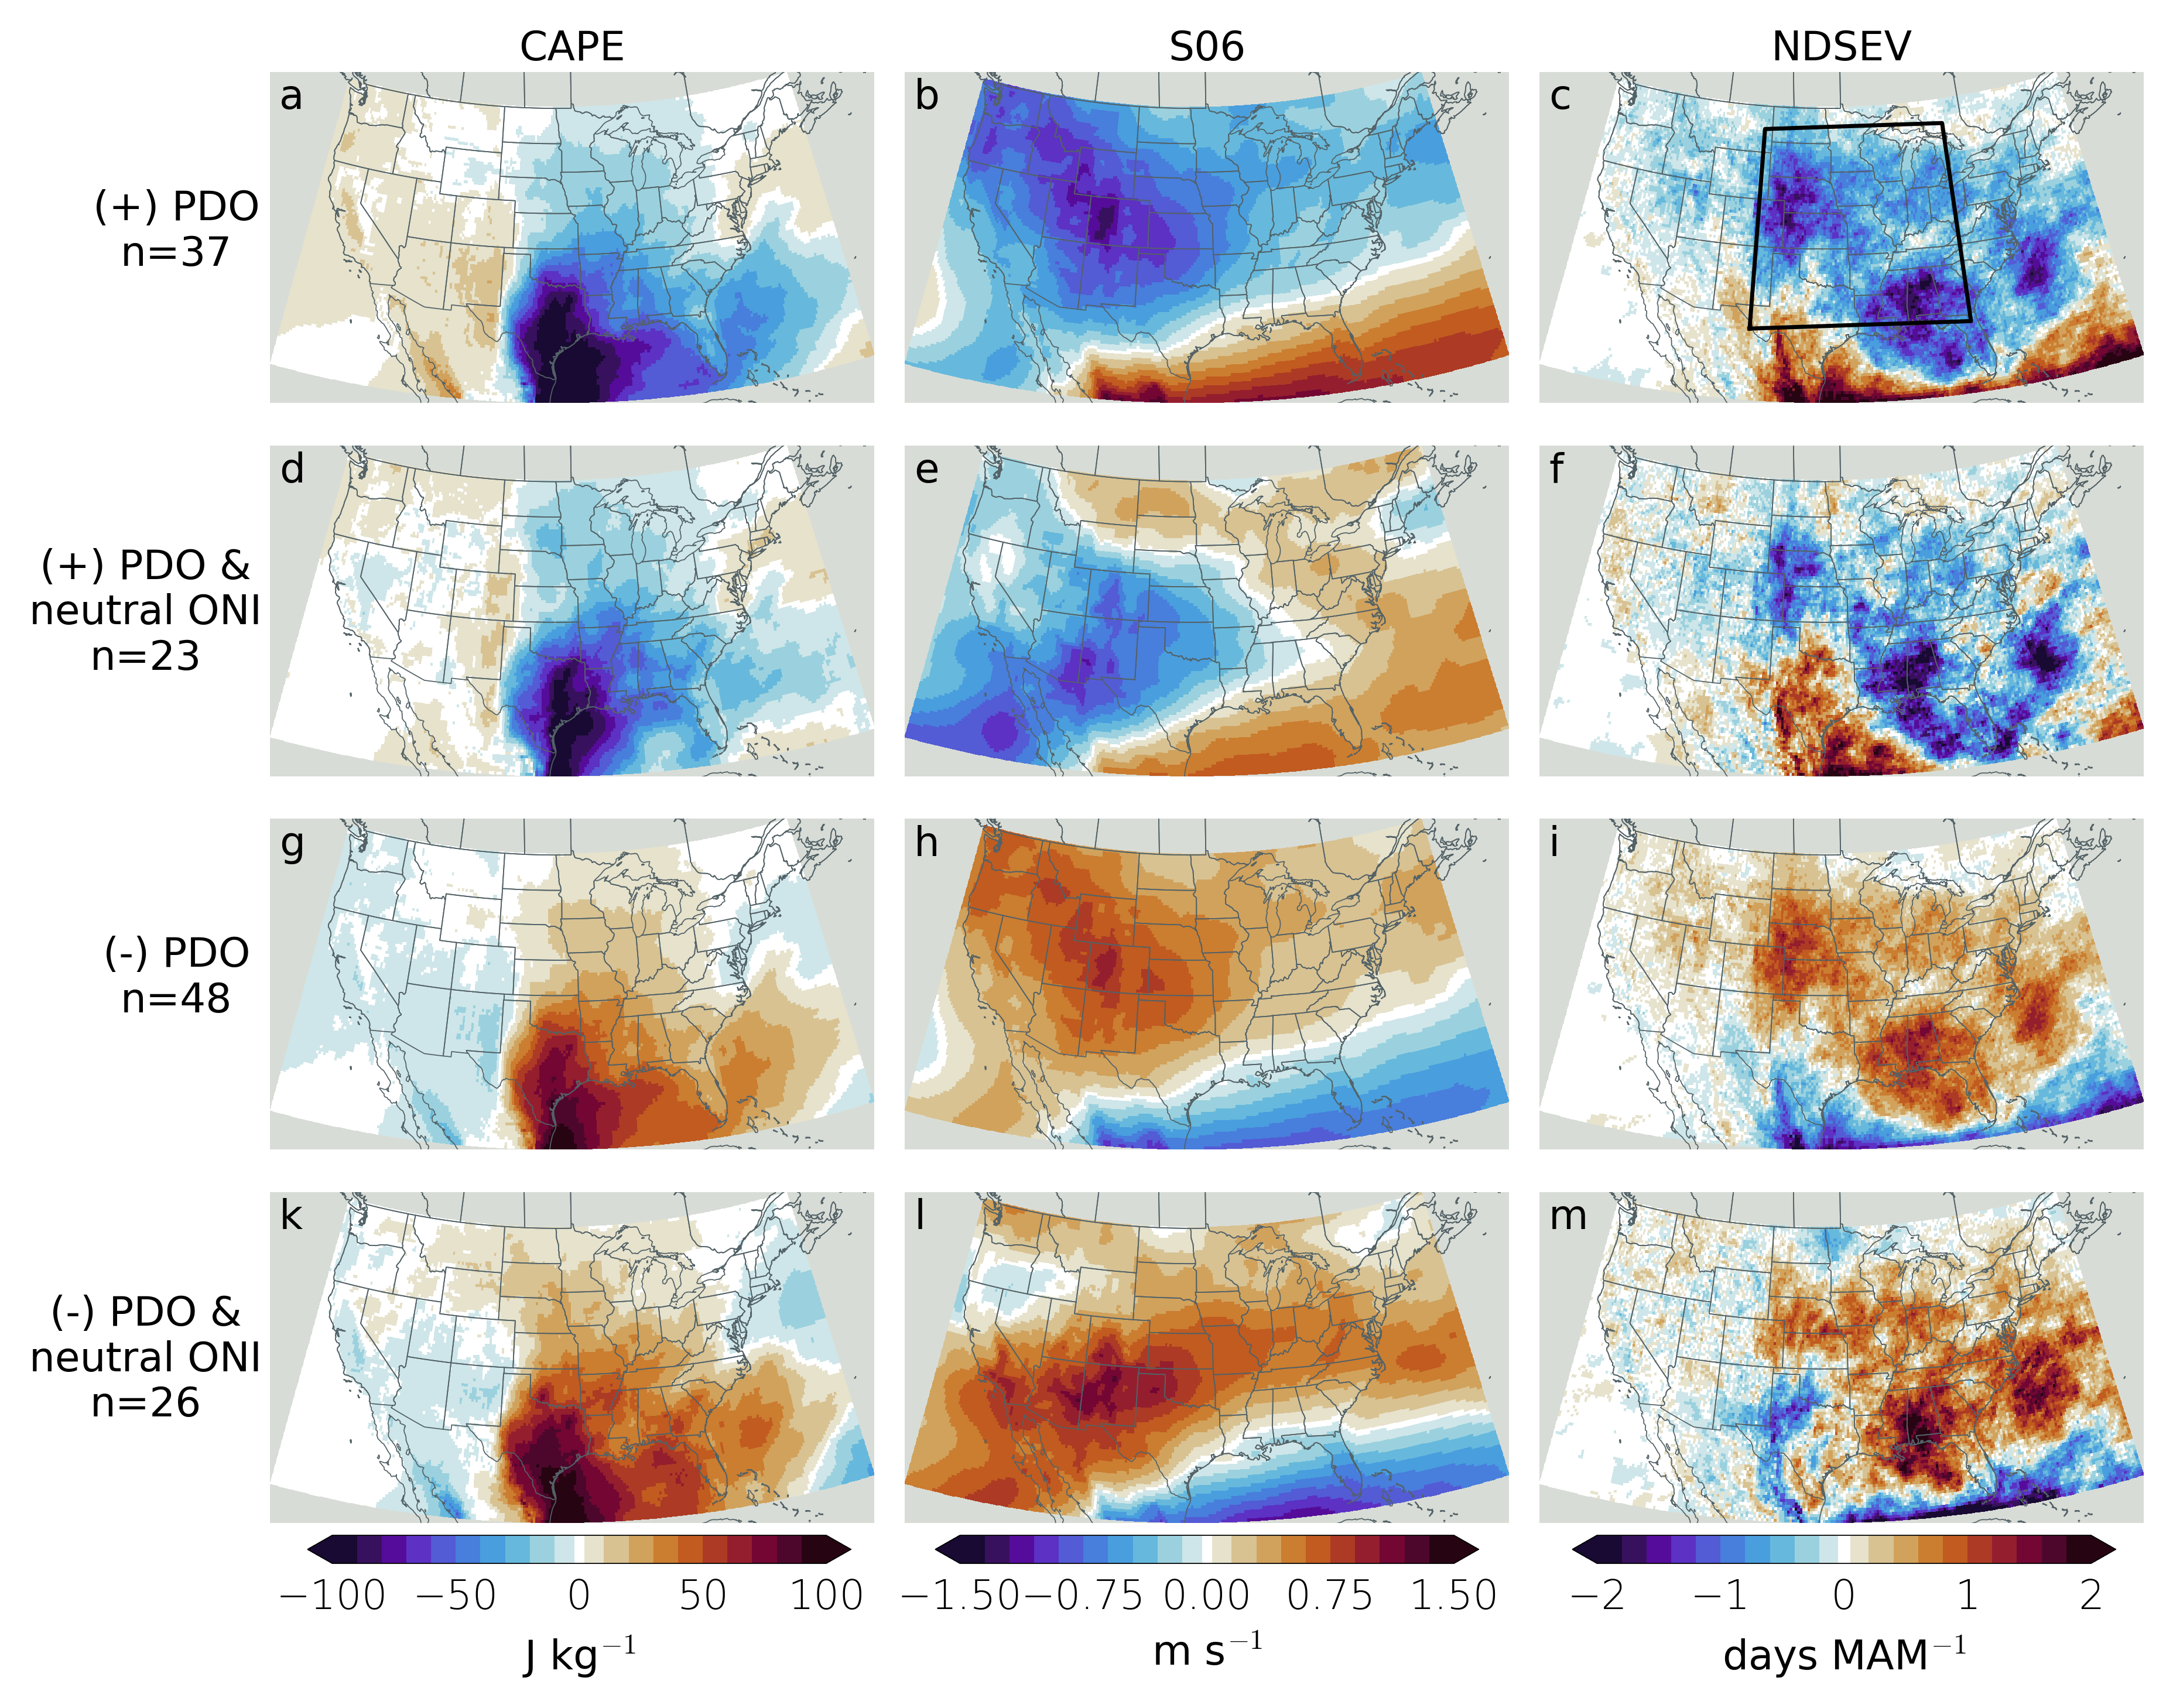

In [178]:
fig, ax = plt.subplots(4, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ndsev_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.05, 0.05, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)

cape_bounds = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, -2, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)

s06_bounds = [-1.5, -1.35, -1.2, -1.05, -0.9, -0.75, -0.6, -0.45, -0.3, -0.15, -0.03, 0.03, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5]
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('cmr.fusion_r').N)

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2], \
      ax[2, 0], ax[2, 1], ax[2, 2], \
      ax[3, 0], ax[3, 1], ax[3, 2]]

lon = ndsev['longitude']
lat = ndsev['latitude']

letters = ['a', 'b', 'c', \
           'd', 'e', 'f', \
           'g', 'h', 'i', \
           'k', 'l', 'm']

for i in range(12):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)

ax[2].pcolormesh(lon, lat, ndsev_pos_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)
ax[5].pcolormesh(lon, lat, ndsev_pos_pdo_neut_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)
ax[8].pcolormesh(lon, lat, ndsev_neg_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)
ax[11].pcolormesh(lon, lat, ndsev_neg_pdo_neut_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[0].pcolormesh(lon, lat, cape_pos_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)
ax[3].pcolormesh(lon, lat, cape_pos_pdo_neut_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)
ax[6].pcolormesh(lon, lat, cape_neg_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)
ax[9].pcolormesh(lon, lat, cape_neg_pdo_neut_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[1].pcolormesh(lon, lat, s06_pos_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)
ax[4].pcolormesh(lon, lat, s06_pos_pdo_neut_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)
ax[7].pcolormesh(lon, lat, s06_neg_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)
ax[10].pcolormesh(lon, lat, s06_neg_pdo_neut_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)

ax[0].contourf(lon, lat, cape_pos_pdo_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[3].contourf(lon, lat, cape_pos_pdo_neut_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[6].contourf(lon, lat, cape_neg_pdo_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[9].contourf(lon, lat, cape_neg_pdo_neut_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[1].contourf(lon, lat, s06_pos_pdo_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[4].contourf(lon, lat, s06_pos_pdo_neut_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[7].contourf(lon, lat, s06_neg_pdo_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[10].contourf(lon, lat, s06_neg_pdo_neut_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[2].contourf(lon, lat, ndsev_pos_pdo_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[5].contourf(lon, lat, ndsev_pos_pdo_neut_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[8].contourf(lon, lat, ndsev_neg_pdo_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[11].contourf(lon, lat, ndsev_neg_pdo_neut_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[2].set_title('NDSEV', pad=3, fontsize=10)
ax[0].set_title('CAPE', pad=3, fontsize=10)
ax[1].set_title('S06', pad=3, fontsize=10)

ax[0].text(-3700000, -100000, f"(+) PDO\nn={len(cape_pos_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-4000000, -400000, f"(+) PDO &\nneutral ONI\nn={len(cape_pos_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[6].text(-3700000, -100000, f"(-) PDO\nn={len(cape_neg_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[9].text(-4000000, -400000, f"(-) PDO &\nneutral ONI\nn={len(cape_neg_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')


cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-100, -50, 0, 50, 100])
cbar.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-1.5, -0.75, 0, 0.75, 1.5])
cbar2.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2, -1, 0, 1, 2])
cbar3.set_label(r'days MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=10, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

lat_min, lat_max = 30, 47
lon_min, lon_max = pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82)
rect_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
rect_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax[2].plot(rect_lons, rect_lats, color='black', lw=1, transform=ccrs.PlateCarree())

mpl.rcParams['hatch.color'] = 'xkcd:gunmetal'
mpl.rcParams['hatch.linewidth'] = 0.375

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.3, 
                    wspace=0.05, 
                    hspace=0.05)

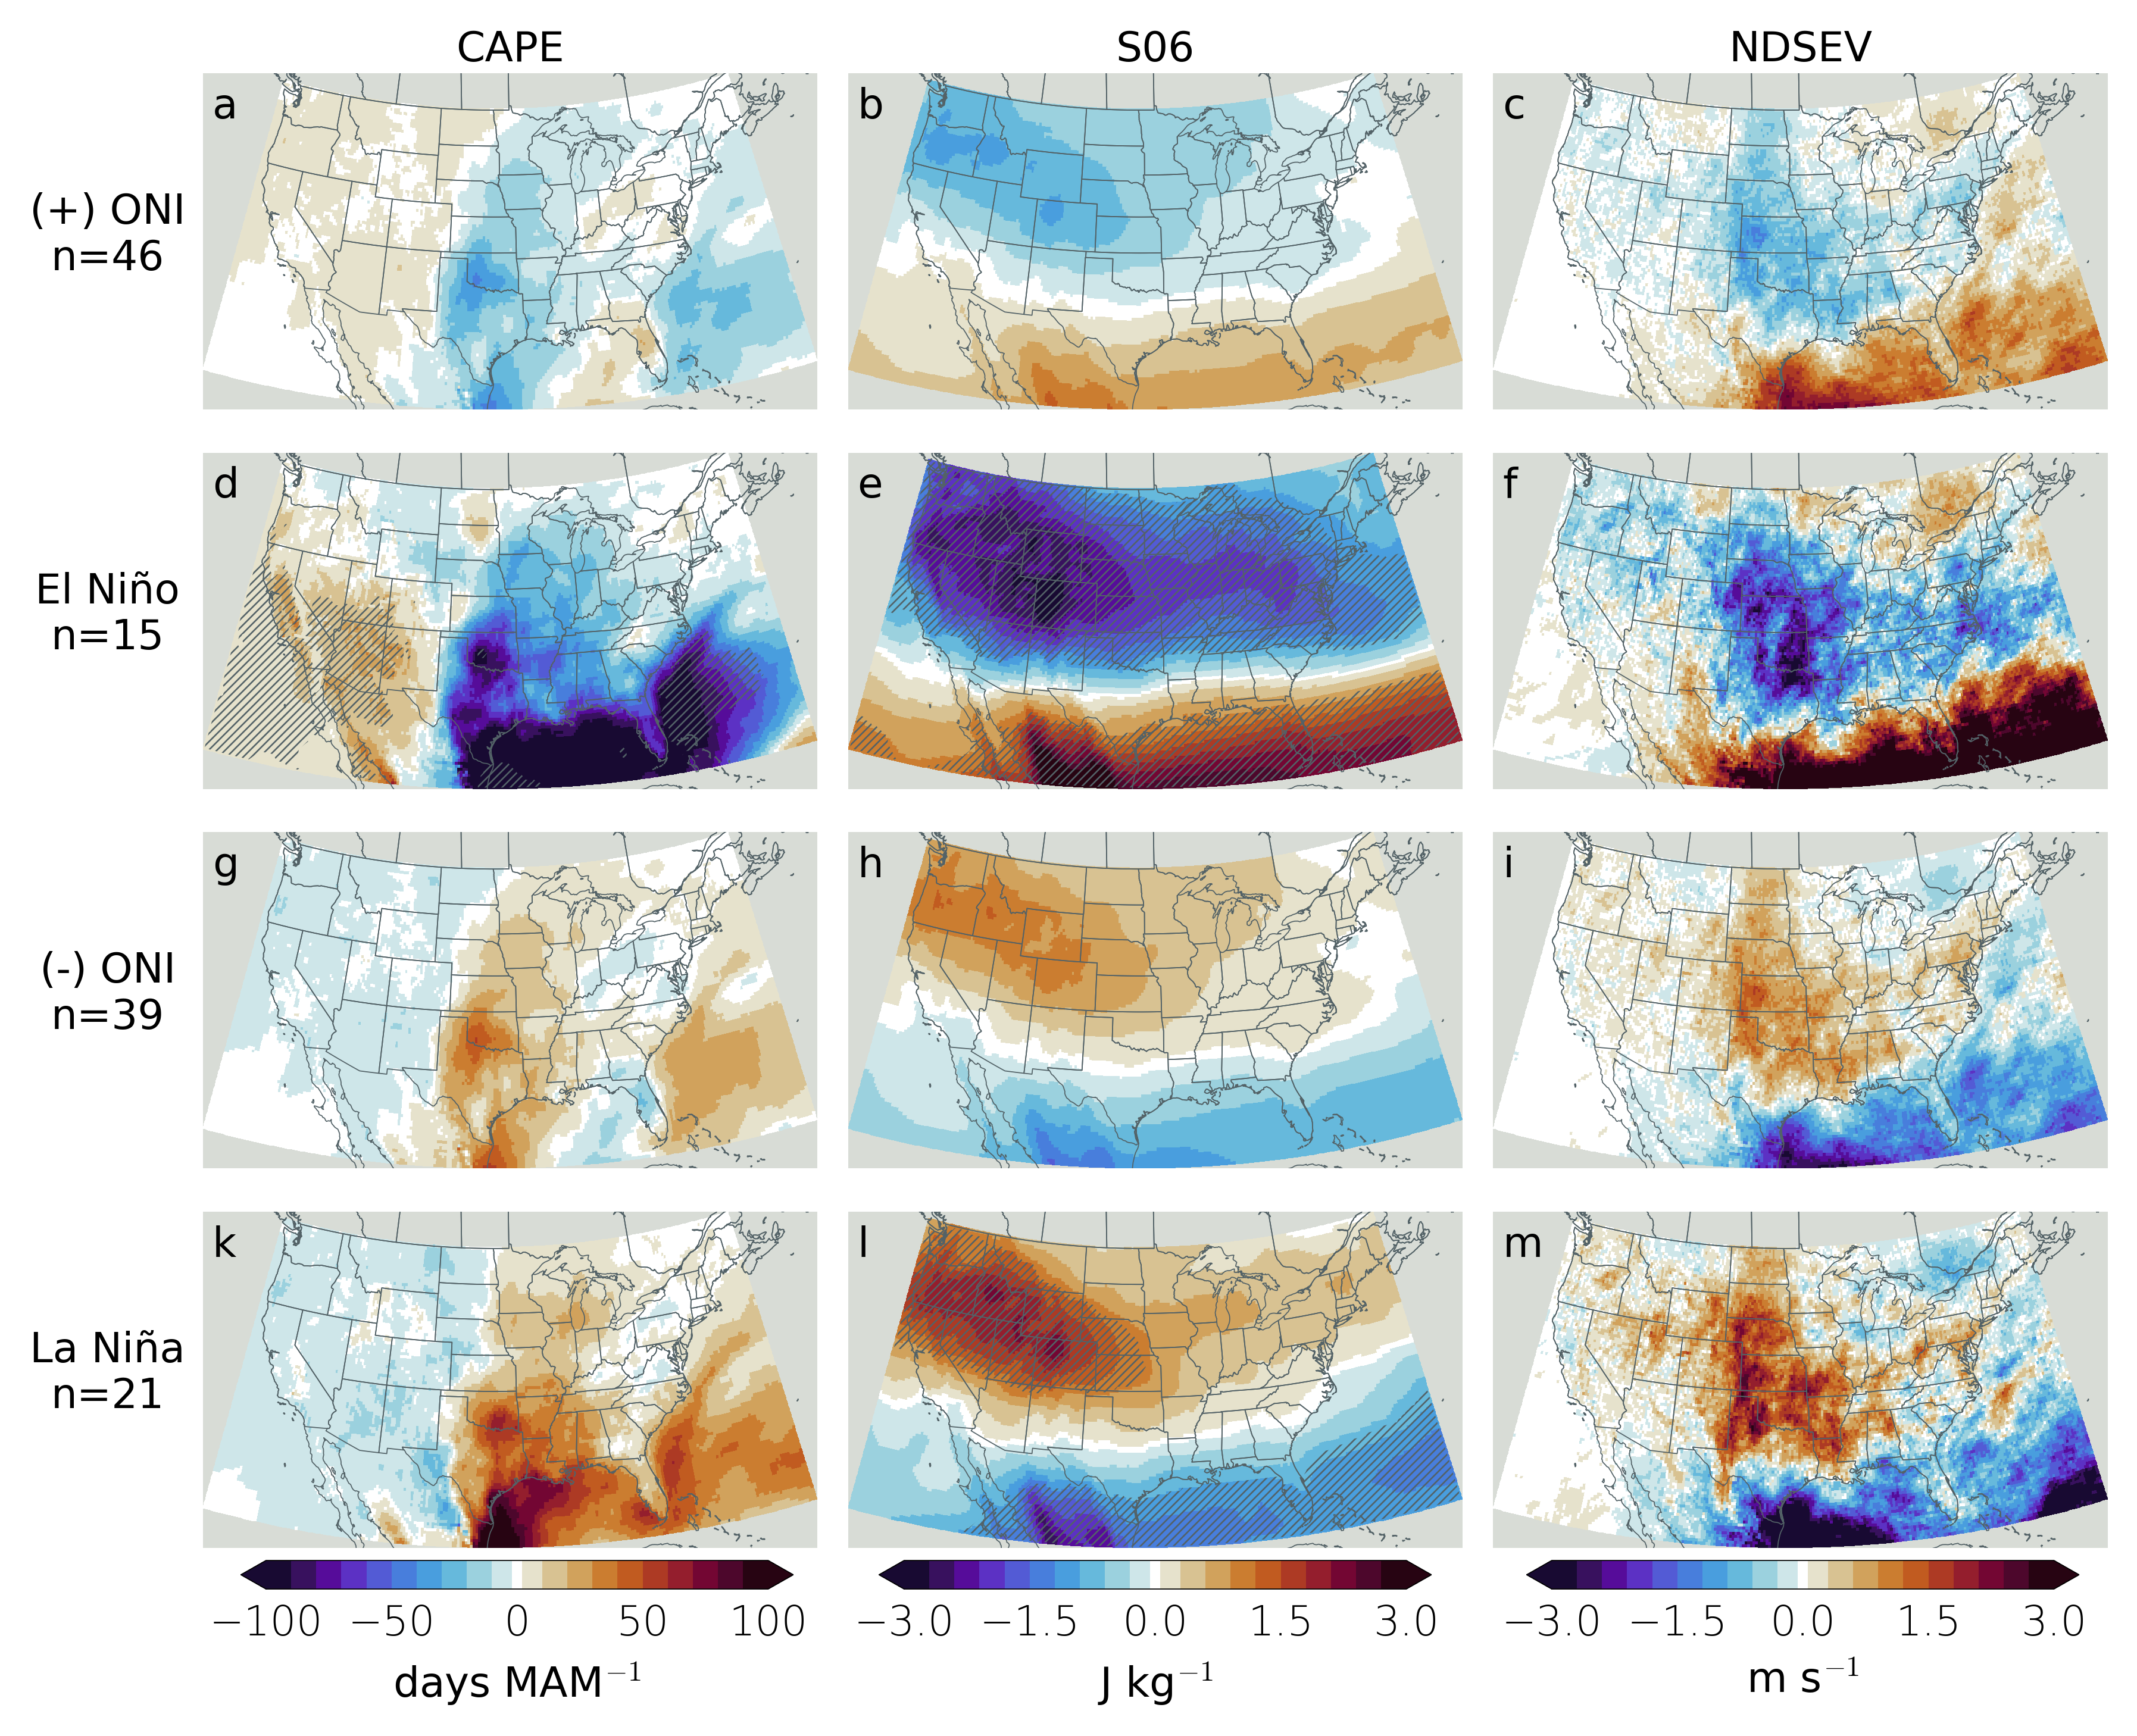

In [177]:
fig, ax = plt.subplots(4, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2], \
      ax[2, 0], ax[2, 1], ax[2, 2], \
      ax[3, 0], ax[3, 1], ax[3, 2]]

letters = ['a', 'b', 'c', \
           'd', 'e', 'f', \
           'g', 'h', 'i', \
           'k', 'l', 'm']

ndsev_nino_bounds = [-3, -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3, -0.06, 0.06, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3]
ndsev_nino_norm = c.BoundaryNorm(ndsev_nino_bounds, plt.get_cmap('cmr.fusion_r').N)

cape_nino_bounds = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, -2, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cape_nino_norm = c.BoundaryNorm(cape_nino_bounds, plt.get_cmap('cmr.fusion_r').N)

s06_nino_bounds = [-3, -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3, -0.06, 0.06, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3]
s06_nino_norm = c.BoundaryNorm(s06_nino_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(12):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1350000, letters[i], fontweight='normal', size=10)

ax[2].pcolormesh(lon, lat, ndsev_pos_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_nino_norm)
ax[8].pcolormesh(lon, lat, ndsev_neg_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_nino_norm)
ax[5].pcolormesh(lon, lat, ndsev_pos_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_nino_norm)
ax[11].pcolormesh(lon, lat, ndsev_neg_nina.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_nino_norm)

ax[0].pcolormesh(lon, lat, cape_pos_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_nino_norm)
ax[6].pcolormesh(lon, lat, cape_neg_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_nino_norm)
ax[3].pcolormesh(lon, lat, cape_pos_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_nino_norm)
ax[9].pcolormesh(lon, lat, cape_neg_nina.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_nino_norm)

ax[1].pcolormesh(lon, lat, s06_pos_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_nino_norm)
ax[7].pcolormesh(lon, lat, s06_neg_oni.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_nino_norm)
ax[4].pcolormesh(lon, lat, s06_pos_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_nino_norm)
ax[10].pcolormesh(lon, lat, s06_neg_nina.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_nino_norm)

ax[0].text(-3700000, -100000, f"(+) ONI\nn={len(cape_pos_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[6].text(-3700000, -100000, f"(-) ONI\nn={len(cape_neg_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-3700000, -100000, f"El Ni\u00f1o\nn={len(cape_pos_nino)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[9].text(-3700000, -100000, f"La Ni\u00f1a\nn={len(cape_neg_nina)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

ax[0].contourf(lon, lat, cape_pos_oni_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[3].contourf(lon, lat, cape_pos_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[6].contourf(lon, lat, cape_neg_oni_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[9].contourf(lon, lat, cape_neg_nina_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[1].contourf(lon, lat, s06_pos_oni_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[4].contourf(lon, lat, s06_pos_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[7].contourf(lon, lat, s06_neg_oni_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[10].contourf(lon, lat, s06_neg_nina_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[2].contourf(lon, lat, ndsev_pos_oni_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[5].contourf(lon, lat, ndsev_pos_nino_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[8].contourf(lon, lat, ndsev_neg_oni_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[11].contourf(lon, lat, ndsev_neg_nina_sig, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])


cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_nino_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-100, -50, 0, 50, 100])
cbar.set_label(r'days MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_nino_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-3, -1.5, 0, 1.5, 3])
cbar2.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_nino_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-3, -1.5, 0, 1.5, 3])
cbar3.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=10, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[2].set_title('NDSEV', pad=3, fontsize=10)
ax[0].set_title('CAPE', pad=3, fontsize=10)
ax[1].set_title('S06', pad=3, fontsize=10)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.3, 
                    wspace=0.05, 
                    hspace=0.05)